# SVM con *scorings*
Prueba de SVM con los scorings calculados con:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import warnings
warnings.filterwarnings('ignore')

Carga del DataFrame Principal:

In [2]:
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")

Carga de los dataframes con los mejores scores de las proteínas para cada programa de *docking*.

## Ensemble Docking con ligandos CSAR
- ### 111 ligandos
    - 27 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [3]:
# Vinardo scoring 16x
df_vinardo_results = pd.read_csv(F'./B_DATOS/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)
y_CSAR = pd.Series(df_vinardo_results.ActiveInactive == "Active", dtype = int)
X_CSAR = df_vinardo_results.drop(["ActiveInactive"], axis = 1)

print("Dims X_CSAR", X_CSAR.shape)

Dims X_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [4]:
# Carga de los datos DUD
# Split de los sets de entrenamiento y prueba
df_vrd_DUD2006 = pd.read_csv(F'./B_DATOS/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)
y_DUD = pd.Series(df_vrd_DUD2006.Actividad == "Active", dtype = int)
X_DUD = df_vrd_DUD2006.drop(["Actividad"], axis = 1)

print("Dims X_DUD", X_DUD.shape)

Dims X_DUD (2146, 402)


In [5]:
# Establecemos los parámetros para graficar
import pylab
pylab.rcParams['figure.figsize'] = (7, 7)
sns.set( context = 'talk', style = 'white', palette = "Set2")

def add_plot_roc(predicted_values, true_values, label = ''):
    # inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, predicted_values)
    auc = roc_auc_score( y_true = true_values, y_score = predicted_values)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 4)

def plot_roc(predicted_values, true_values, label = '', titulo = "ROC curve"):
    sns.color_palette("Paired")
    add_plot_roc(predicted_values, true_values, label)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

# SVM Lineal con Vinardo 16x
## Dataset Completo

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Función para ejecutar el SVM
1. Recibe como entrada los sets de entrenamiento y de prueba.
2. Crea un *Pipeline* para trabajar sobre el *X_train*.
    - Estandariza los datos del X_train.
    - Crea la instancia del clasificador lineal.
3. Lleva a cabo el *Grid search* para  determinar los mejores parámetros del modelo (*C*).
4. Obtiene el mejor modelo al finalizar el *Grid search*.
5. El *mejor modelo* es usado para predecir sobre *X_test*.
    - Se obtiene **y_pred** con las predicciones (1 = activo y 0 = inactivo).
    - Se obtiene **y_score** con las distancias de las predicciones al hiperplano. +Estas se usarán para calcular las curvas ROC.
6. Se imprimen algunas métricas de **y_pred** vs **y_test**.
7. Se grafica la curva ROC.

In [7]:
def run_SVM(X_train, X_test, y_train, y_test):
    # Determina el mejor modelo usando grid search y validación cruzada
    #best_clasifier = run_CV(X_train, y_train)
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()), # Realiza la estandarización sobre el X_train
            ("SVC", SVC(kernel='linear', probability = True))
        ])

    parametros = {'SVC__C': [10**i for i in range(-3, 4)]}
    linear_SVC = GridSearchCV(SVCpipe, parametros, 
                             scoring = 'roc_auc',
                             cv = 5, return_train_score = True)
    # Entrenamiento con el grid
    linear_SVC.fit(X_train, y_train)
    # Retorna el mejor modelo
    best_clasifier = linear_SVC.best_estimator_
    
    # Realiza la estandarización sobre el X_test
    X_test = StandardScaler().fit_transform(X_test)
    
    # Predicciones sobre X_test
    y_pred = best_clasifier.predict(X_test) # Valores predichos
    y_score = best_clasifier.decision_function(X_test) # Distancia al hiperplano
    # Genera algunos outputs
    print('MÉTRICAS')
    print("Accuracy:", metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    print("Precision:",metrics.precision_score(y_true = y_test, y_pred = y_pred))
    print("Recall:",metrics.recall_score(y_true = y_test, y_pred = y_pred))
    print('')
    # Matirz de confusión
    print('Matriz de confusión:\n', confusion_matrix(y_true = y_test, y_pred = y_pred))
    # AUC
    print("AUC ROC:", roc_auc_score( y_true = y_test, y_score = y_score))
    # Plot del ROC
    plot_roc(y_score, y_test, titulo = "ROC curve")

## Primer modelo
### CSAR (train) / CSAR (test) - Todas las conformaciones
Usamos sólo los resultados del Ensemble Docking con los ligandos de CSAR.

Set de Entrenamiento: 21/88 activos.
Set de Prueba: 5/23 activos.



/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MÉTRICAS
Accuracy: 0.8695652173913043
Precision: 0.6666666666666666
Recall: 0.8

Matriz de confusión:
 [[16  2]
 [ 1  4]]
AUC ROC: 0.8888888888888888


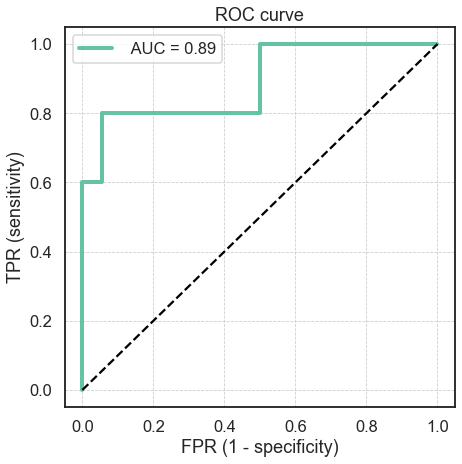

In [8]:
# Split del dataset para obtener train y test
X_train, X_test, y_train, y_test = train_test_split(X_CSAR , y_CSAR, 
                                                    test_size = 0.2, stratify = y_CSAR, random_state = 1)
# Imprimimos cuantos positivos y negativos tenemos en cada set
print(F'Set de Entrenamiento: {y_train.sum()}/{y_train.count()} activos.')
print(F'Set de Prueba: {y_test.sum()}/{y_test.count()} activos.')
print('')
# Ejecutamos el SVM
run_SVM(X_train, X_test, y_train, y_test)

## Segundo Modelo
### CSAR (train) / DUD (test) - Todas las conformaciones
No necesitamos hacer el split, ahora CSAR servirá como conjunto de entrenamiento y validación, y DUD como conjunto de prueba.

Set de Entrenamiento: 26/111 activos.
Set de Prueba: 72/2146 activos.



/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


MÉTRICAS
Accuracy: 0.8392357875116496
Precision: 0.10888252148997135
Recall: 0.5277777777777778

Matriz de confusión:
 [[1763  311]
 [  34   38]]
AUC ROC: 0.8047385620915033


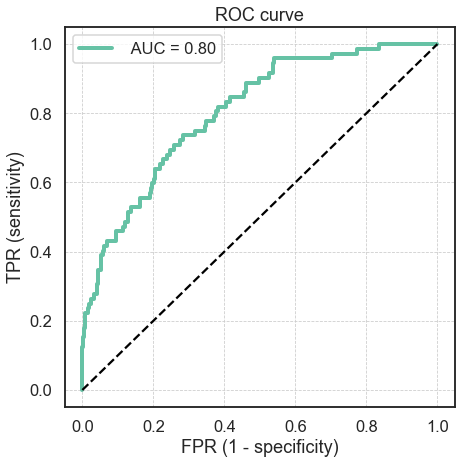

In [9]:
X_train = X_CSAR
y_train = y_CSAR

X_test = X_DUD
y_test = y_DUD

# Imprimimos cuantos positivos y negativos tenemos en cada set
print(F'Set de Entrenamiento: {y_train.sum()}/{y_train.count()} activos.')
print(F'Set de Prueba: {y_test.sum()}/{y_test.count()} activos.')
print('')
# Ejecutamos el SVM
run_SVM(X_train, X_test, y_train, y_test)